In [1]:
from FairFront import FairFront
from DiscreteFairFront import *
import numpy as np
import cvxpy as cp
import dccp

import sys
import pandas as pd
import numpy as np

import random
import pickle
import time
from tqdm import tqdm
from time import localtime, strftime

import matplotlib.pyplot as plt

In [2]:
# load the pre-processed HSLS dataset
df = pd.read_pickle("../data/HSLS/hsls_discretized_multis.pkl")  


In [6]:
seed_n = 42
random.seed(seed_n)
np.random.seed(seed_n)

In [7]:
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_pickle("../data/HSLS/hsls_discretized_multis.pkl")  

In [8]:
# can also follow the below code to obtain processed and discretized HSLS dataset from scratch
# need to download the original dataset hsls_17_student_pets_sr_v1_0.csv from https://nces.ed.gov/datalab/onlinecodebook/session/codebook/53856922-1e88-4282-8dea-3d884bbc5373
df_orig = pd.read_csv('../data/HSLS/hsls_17_student_pets_sr_v1_0.csv')

In [9]:
vars = ['X1MTHID', 'X1MTHUTI', 'X1MTHEFF', 'X1PAR1EDU','X1PAR2EDU', 'X1FAMINCOME',
        'X1PAR1EMP','X1PAR2EMP', 'X1SCHOOLBEL','X1RACE', 'X1SEX','X1TXMSCR']
df = df_orig[vars]
df[df <= -7] = np.nan
df = df[vars]
df = df.dropna()

#df['racebin'] = np.logical_or((df['X1RACE'] == 8).values, (df['X1RACE'] == 2).values).astype(int)
df['sexbin'] = (df['X1SEX'] == 1).astype(int)
# plt.hist(df['X1TXMSCR'].unique())

def get_race_bin(row):
    ''' 
    Race as a 4-class ensitive attributes: White, African American, Asian, Others
    '''
    if row['X1RACE'] == 2:
        # Asian
        return  0
    elif row['X1RACE'] == 8:
        # White 
        return 1 
    elif row['X1RACE'] == 3:
        # African American 
        return 2
    else:
        # All others
        return 3

        




def get_grade_discrete(row):
    '''
    Discretize the X1TXMSCR (target) column
    X1TXMSCR: X1 Mathematics IRT-estimated number right score (of 72 base year items)
    '''
    if row['X1TXMSCR'] < 30:
        return 0
    elif  row['X1TXMSCR'] >= 30 and  row['X1TXMSCR'] < 40:
        return 1
    elif  row['X1TXMSCR'] >= 40 and  row['X1TXMSCR'] < 50:
        return 2
    elif row['X1TXMSCR'] >= 50 and  row['X1TXMSCR'] < 60:
        return 3
    else:
        return 4

def get_X1MTHID_discrete(row):
    '''
    Discretize the X1MTHID column by standard deviation (1) from mean (0).
    X1MTHID: Scale of student's mathematics identity
    '''
    if row['X1MTHID'] < -1:
        return 0
    elif  row['X1MTHID'] >= -1 and  row['X1MTHID'] < 0:
        return 1
    elif  row['X1MTHID'] >= 0 and  row['X1MTHID'] < 1:
        return 2
    elif row['X1MTHID'] >= 1:
        return 3

def get_X1MTHUTI_discrete(row):
    '''
    Discretize the X1MTHID column by standard deviation (1) from mean (0).
    X1MTHID: Scale of student's mathematics utility
    '''
    if row['X1MTHUTI'] < -1:
        return 0
    elif  row['X1MTHUTI'] >= -1 and  row['X1MTHUTI'] < 0:
        return 1
    elif  row['X1MTHUTI'] >= 0 and  row['X1MTHUTI'] < 1:
        return 2
    elif row['X1MTHUTI'] >= 1:
        return 3

def get_X1MTHEFF_discrete(row):
    '''
    Discretize the X1MTHEFF column by standard deviation (1) from mean (0).
    X1MTHEFF: Scale of student's mathematics self-efficacy
    '''
    if row['X1MTHEFF'] < -1:
        return 0
    elif  row['X1MTHEFF'] >= -1 and  row['X1MTHEFF'] < 0:
        return 1
    elif  row['X1MTHEFF'] >= 0 and  row['X1MTHEFF'] < 1:
        return 2
    elif row['X1MTHEFF'] >= 1 :
        return 3

def get_X1SCHOOLBEL_discrete(row):
    '''
    Discretize the X1SCHOOLBEL column by standard deviation (1) from mean (0).
    X1SCHOOLBEL: Scale of student's sense of school belonging
    '''
    if row['X1SCHOOLBEL'] < -1:
        return 0
    elif  row['X1SCHOOLBEL'] >= -1 and  row['X1SCHOOLBEL'] < 0:
        return 1
    elif  row['X1SCHOOLBEL'] >= 0 and  row['X1SCHOOLBEL'] < 1:
        return 2
    elif row['X1SCHOOLBEL'] >= 1:
        return 3

df['grade'] = df.apply(lambda x: get_grade_discrete(x), axis=1)
df['X1MTHID'] = df.apply(lambda x: get_X1MTHID_discrete(x), axis=1)
df['X1MTHUTI'] = df.apply(lambda x: get_X1MTHUTI_discrete(x), axis=1)
df['X1MTHEFF'] = df.apply(lambda x: get_X1MTHEFF_discrete(x), axis=1)
df['X1SCHOOLBEL'] = df.apply(lambda x: get_X1SCHOOLBEL_discrete(x), axis=1)
df['racebin'] = df.apply(lambda x: get_race_bin(x), axis=1)

# drop the original columns that have been processed
df.drop(['X1TXMSCR', 'X1RACE', 'X1SEX'],inplace=True,axis=1)

/var/folders/wy/0ztznwwn71nb8mt339lkjn4c0000gn/T/ipykernel_8563/3303450682.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df <= -7] = np.nan
/var/folders/wy/0ztznwwn71nb8mt339lkjn4c0000gn/T/ipykernel_8563/3303450682.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df <= -7] = np.nan


(array([ 952.,    0.,    0., 6667.,    0.,    0.,  700.,    0.,    0.,
        2618.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

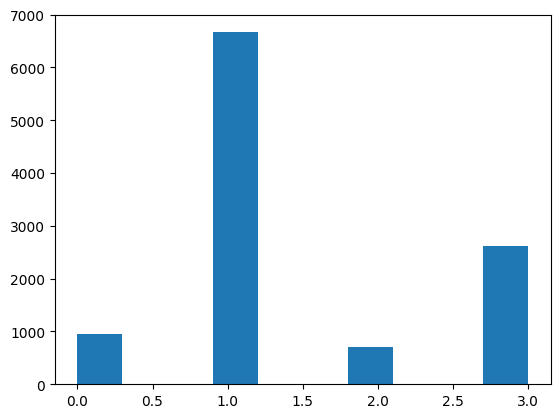

In [10]:
plt.hist(df['racebin'])
# df['racebin']

In [11]:
len(df)

10937

In [12]:
# X1MTHID: “You see yourself as a math person” and/or “Others see me as a
# math person” will have higher values for X1MTHID.

# X1MTHUTI: X1 Scale of student's mathematics utility

# X1MTHEFF: This variable is a scale of the sample member’s mathematics self-efficacy; higher X1MTHEFF
# values represent higher mathematics self-efficacy.

# X1PAR2EDU: parent2's highest education level [This should be changed to 1]

# X1FAMINCOME: Total family income from all sources in 2008 

# 'X1P1RELATION':  relationship to 9th grader 

# X1PAR1EMP employment status 

# X1SCHOOLBEL: X1 Scale of student's sense of school belonging

In [13]:
# add a SY column
def get_SY_column(row):
    racebin = row['racebin']
    grade = row['grade']
    return 5*racebin + grade 

df['SY'] = df.apply(lambda x: get_SY_column(x), axis=1)


array([ 8.,  6.,  7.,  2.,  3.,  9., 18., 16.,  4.,  5., 14., 17., 11.,
       12., 15., 19.,  1., 13., 10.,  0.])

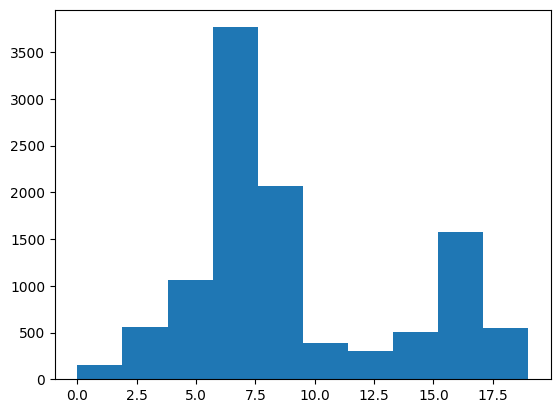

In [14]:
# plt.hist(df['X1MTHUTI'])
plt.hist(df['SY'])
df['SY'].unique()


In [15]:
df.describe()
df.columns

Index(['X1MTHID', 'X1MTHUTI', 'X1MTHEFF', 'X1PAR1EDU', 'X1PAR2EDU',
       'X1FAMINCOME', 'X1PAR1EMP', 'X1PAR2EMP', 'X1SCHOOLBEL', 'sexbin',
       'grade', 'racebin', 'SY'],
      dtype='object')

### Approximate with discrete r.v.

In [16]:
# select useful columns for computing FairFront
used_columns_names = ['X1MTHID', 'X1MTHUTI', 'X1MTHEFF','X1PAR1EDU',
       'X1FAMINCOME', 'X1SCHOOLBEL', 'racebin',
       'sexbin', 'SY']
used_columns = df[used_columns_names]

#'X1PAR1EMP', 'X1PAR2EMP',  'X1PAR1EDU', 'X1PAR2EDU',


In [17]:
pmf_dict = {0:{}, 1:{}, 2:{}, 3:{}, 4:{}, 5:{}, 6:{}, 7:{}, 8:{}, 9:{},
            10:{}, 11:{}, 12:{}, 13:{}, 14:{}, 15:{}, 16:{}, 17:{}, 18:{}, 19:{}}

def get_type_count(row):
    sy = row['SY']
    key = ()
    for column_name in used_columns_names[:-1]: # loop through column names except for 'SY'
        key = key + (row[column_name],) 
    if key not in pmf_dict[sy]:
        pmf_dict[sy].update({key: 1})
    else:
        pmf_dict[sy][key] =  pmf_dict[sy][key] + 1
             

for index, row in used_columns.iterrows():
    get_type_count(row)

for i in range(20):
    total_i = sum(pmf_dict[i].values())
    pmf_dict[i] = {key: value / total_i for key, value in pmf_dict[i].items()}


In [18]:
pmf_dict

{0: {(2.0, 1.0, 2.0, 4.0, 5.0, 2.0, 0.0, 1.0): 0.02040816326530612,
  (1.0, 1.0, 2.0, 5.0, 6.0, 2.0, 0.0, 0.0): 0.02040816326530612,
  (3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 0.0, 1.0): 0.02040816326530612,
  (1.0, 3.0, 1.0, 4.0, 11.0, 1.0, 0.0, 1.0): 0.02040816326530612,
  (1.0, 3.0, 3.0, 3.0, 2.0, 3.0, 0.0, 1.0): 0.02040816326530612,
  (2.0, 2.0, 3.0, 2.0, 2.0, 3.0, 0.0, 1.0): 0.02040816326530612,
  (2.0, 1.0, 1.0, 4.0, 4.0, 1.0, 0.0, 0.0): 0.02040816326530612,
  (2.0, 1.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0): 0.02040816326530612,
  (0.0, 1.0, 0.0, 4.0, 4.0, 1.0, 0.0, 0.0): 0.02040816326530612,
  (3.0, 2.0, 2.0, 4.0, 3.0, 3.0, 0.0, 1.0): 0.02040816326530612,
  (0.0, 0.0, 1.0, 2.0, 4.0, 1.0, 0.0, 0.0): 0.02040816326530612,
  (2.0, 1.0, 1.0, 2.0, 4.0, 1.0, 0.0, 0.0): 0.02040816326530612,
  (1.0, 1.0, 2.0, 4.0, 5.0, 1.0, 0.0, 0.0): 0.04081632653061224,
  (2.0, 1.0, 1.0, 3.0, 6.0, 1.0, 0.0, 1.0): 0.02040816326530612,
  (3.0, 3.0, 2.0, 2.0, 2.0, 3.0, 0.0, 1.0): 0.02040816326530612,
  (2.0, 1.0, 0.0, 2.0

In [19]:
# output support as a list 
support_list = []
for i in range(20):
    support_list += list(pmf_dict[i].keys())

support_X = list(set(support_list)) # support of input features
calX = len(support_X)# support size of input features
calX


7783

In [20]:
def get_pmf(dictionary, x):
    '''
    if x is in dictionary pmf_dict[i], then use that value. If not, fill in 0
    '''
    if x in dictionary:
        return dictionary[x]
    else:
        return 0 

# transition matrix from (s,y) to x
T_SY_X  = np.vstack([[get_pmf(pmf_dict[i], x) for x in support_X] for i in range(20)])

T_SY_X.shape

# can then use it to generate approximate for True FairFront

(20, 7783)

#### Obtain transition matrix and conditional distribution

In [21]:
A = 4
C = 5
sensitive_s = 'racebin'
label_y = 'grade'
# get the mu_s,y values, encoded in matrix mu_SY
mu_SY = np.zeros((A, C))
for index, row in df.iterrows():
    s,y = int(row[sensitive_s]), int(row[label_y])
    mu_SY[s][y] = mu_SY[s][y] + 1
mu_SY = mu_SY/len(df)

map_ind_X = dict(zip(range(calX), support_X))
map_X_ind = dict(zip(support_X, range(calX)))

In [22]:
def g_emp(x):
    '''
    compute g function from the empirical distribution
    '''
    result_vector = []
    ind_x = map_X_ind[x]
    for s in range(A):
        for y in range(C):
            result_vector.append(T_SY_X[s*C + y, ind_x] * mu_SY[s][y])
    #normalize
    result_vector = result_vector/(sum(result_vector))
    return result_vector

In [23]:
distinf = {"T": T_SY_X, "map": map_ind_X, "mu_SY": mu_SY}

In [24]:
T_SY_X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00980392, 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Generate FairFront 

In [ ]:
# generate fair front example

# fairness threshold
alpha_SP = 1.0
alpha_OAE = 1.0
alpha_EO = 0.1

start_time = time.localtime()
FairFront_value = FairFront(A, C, g_emp,sensitive_s = sensitive_s, label_y=label_y,InputDist = True, dist_inf = distinf, alpha_SP = alpha_SP, alpha_EO = alpha_EO , alpha_OAE = alpha_OAE, max_iterations = 40)
optimal_value,_,_ = FairFront_value.Algorithm()

print('Time: {:4.3f} mins\n'.format((time.mktime(time.localtime()) - time.mktime(start_time))/60))
print('optimal value:', optimal_value)  

In [29]:
# fairness threshold (only varying EO in the following code, can modify to incorporate multiple constraints)
alpha_SP = 1
alpha_OAE = 1

In [30]:
# the sharp curve part, faster simulation with discrete FairFront
A = 4
C = 5

epsilon = []
opt_list = [] # List of FairFront values
opt_discrete_list = []

for i in np.linspace(0,0.22,15): 
    print("current i:", i)
    epsilon.append(i)
    start_time = time.localtime()
    #FairFront_value = FairFront(A, C, g_emp,sensitive_s = sensitive_s, label_y=label_y,InputDist = True, dist_inf = distinf, alpha_SP = alpha_SP, alpha_EO = i , alpha_OAE = alpha_OAE, max_iterations = 20)

    #optimal_value,_,_ = FairFront_value.Algorithm()
    #opt_list.append(optimal_value)
    
    
    FairFront_discrete = DiscreteFairFront(A, C, mu_SY, distinf, alpha_SP = alpha_SP, alpha_EO = i, alpha_OAE = alpha_OAE)
    value = FairFront_discrete.FairFront()

    opt_discrete_list.append(value)
    
    
    print('Time for this iteration: {:4.3f} mins\n'.format((time.mktime(time.localtime()) - time.mktime(start_time))/60))
    print("opt_list:", opt_discrete_list)

current i: 0.0
Time for this iteration: 0.217 mins

opt_list: [0.778827303002725]
current i: 0.015714285714285715
Time for this iteration: 0.217 mins

opt_list: [0.778827303002725, 0.784962440104888]
current i: 0.03142857142857143
Time for this iteration: 0.233 mins

opt_list: [0.778827303002725, 0.784962440104888, 0.7910975777855254]
current i: 0.047142857142857146
Time for this iteration: 0.233 mins

opt_list: [0.778827303002725, 0.784962440104888, 0.7910975777855254, 0.797232713509818]
current i: 0.06285714285714286
Time for this iteration: 0.233 mins

opt_list: [0.778827303002725, 0.784962440104888, 0.7910975777855254, 0.797232713509818, 0.803250897021703]
current i: 0.07857142857142857
Time for this iteration: 0.250 mins

opt_list: [0.778827303002725, 0.784962440104888, 0.7910975777855254, 0.797232713509818, 0.803250897021703, 0.8080698140751129]
current i: 0.09428571428571429
Time for this iteration: 0.233 mins

opt_list: [0.778827303002725, 0.784962440104888, 0.7910975777855254,

In [31]:
# the flat curve part
for i in np.linspace(0.22, 0.35, 10):
    print("current i:", i)
    epsilon.append(i)
    start_time = time.localtime()
    #FairFront_value = FairFront(A, C, g_emp,sensitive_s = sensitive_s, label_y=label_y,InputDist = True, dist_inf = distinf, alpha_SP = alpha_SP, alpha_EO = i , alpha_OAE = alpha_OAE, max_iterations = 20)

    #optimal_value,_,_ = FairFront_value.Algorithm()
    #opt_list.append(optimal_value)

    FairFront_discrete = DiscreteFairFront(A, C, mu_SY, distinf, alpha_SP = alpha_SP, alpha_EO = i, alpha_OAE = alpha_OAE)
    value = FairFront_discrete.FairFront()

    opt_discrete_list.append(value)
    
    
    print('Time for this iteration: {:4.3f} mins\n'.format((time.mktime(time.localtime()) - time.mktime(start_time))/60))
    print("opt_list:", opt_discrete_list)

        

current i: 0.22
Time for this iteration: 0.283 mins

opt_list: [0.778827303002725, 0.784962440104888, 0.7910975777855254, 0.797232713509818, 0.803250897021703, 0.8080698140751129, 0.8108344163706973, 0.8132080078362457, 0.8154766079618098, 0.8175629763219405, 0.8193563587463929, 0.8198774795274241, 0.8198774799905998, 0.819877479804662, 0.8198774799010888, 0.8198774799010888]
current i: 0.23444444444444446
Time for this iteration: 0.250 mins

opt_list: [0.778827303002725, 0.784962440104888, 0.7910975777855254, 0.797232713509818, 0.803250897021703, 0.8080698140751129, 0.8108344163706973, 0.8132080078362457, 0.8154766079618098, 0.8175629763219405, 0.8193563587463929, 0.8198774795274241, 0.8198774799905998, 0.819877479804662, 0.8198774799010888, 0.8198774799010888, 0.8198774799206874]
current i: 0.24888888888888888
Time for this iteration: 0.267 mins

opt_list: [0.778827303002725, 0.784962440104888, 0.7910975777855254, 0.797232713509818, 0.803250897021703, 0.8080698140751129, 0.8108344163

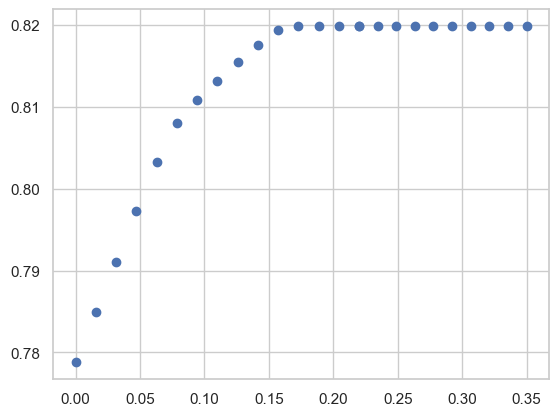

In [32]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
sns.set(style="whitegrid")

plt.plot(epsilon, opt_discrete_list, 'o')